# Anomaly Detection using Rolling Window Approach

In [243]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("poster")

In [244]:
def generate_dataset(min_limit = 1, max_limit = 3, no_instances = 100):
    x = 9.85*np.random.random_integers(min_limit, max_limit, no_instances)
    y = np.arange(0, no_instances)
    return x, y

def add_random_spike(dataset, after_this_point, num_of_spikes):
    max_val = np.max(dataset)
    range_min = after_this_point +  1
    range_max = dataset.shape[0]
    
    for i in range(num_of_spikes):
        rand_pos = np.random.randint(range_min, range_max)
        dataset[rand_pos] = max_val*(1.1 + np.random.random())
        
    return dataset
    

def do_training(dataset, training_set_size = 50, window_size = 10):
    rolling_dataset_size = training_set_size - window_size + 1
    training_features = np.zeros((rolling_dataset_size, window_size))
    training_predictions = np.zeros((rolling_dataset_size))
    
    for i in range(rolling_dataset_size):
        training_features[i,:] = dataset[i: i + window_size]
        training_predictions[i] = dataset[window_size + i]        
    
    lr = LinearRegression(normalize=True)
    lr.fit(training_features, training_predictions)    
    return lr, training_features[rolling_dataset_size -1, :]


def pridict(model, dataset, last_window, training_set_size = 50, window_size = 10, outline_cutoff = None):
    working_dataset = np.copy(dataset)
    testing_features = last_window  
    
    predictions_index = np.zeros((dataset.shape[0] - training_set_size) - 1)
    predictions = np.zeros((dataset.shape[0] - training_set_size - 1), dtype=float)
    outliners = []
    
    if outline_cutoff is None:
        train_max = np.max(dataset[0:training_set_size])
        outline_cutoff = train_max / 10.0
        print outline_cutoff
    
    for i in range(working_dataset.shape[0] - training_set_size - 1):
        testing_features = np.roll(testing_features, -1)
        testing_features[window_size -1] = working_dataset[training_set_size + i]
        actual = dataset[training_set_size + i + 1]
        #print testing_features
        prediction = model.predict(testing_features.reshape(1, -1))[0]
        #print prediction
        
        predictions_index[i] = training_set_size + i 
        predictions[i] = prediction
        if abs(actual - prediction) > outline_cutoff:            
            working_dataset[training_set_size + i + 1] = prediction
            outliners.append([training_set_size + i + 1, actual])
            
    return predictions, predictions_index, outliners

## Detecting Anomalies in Actual Time Series Dataset

81.1


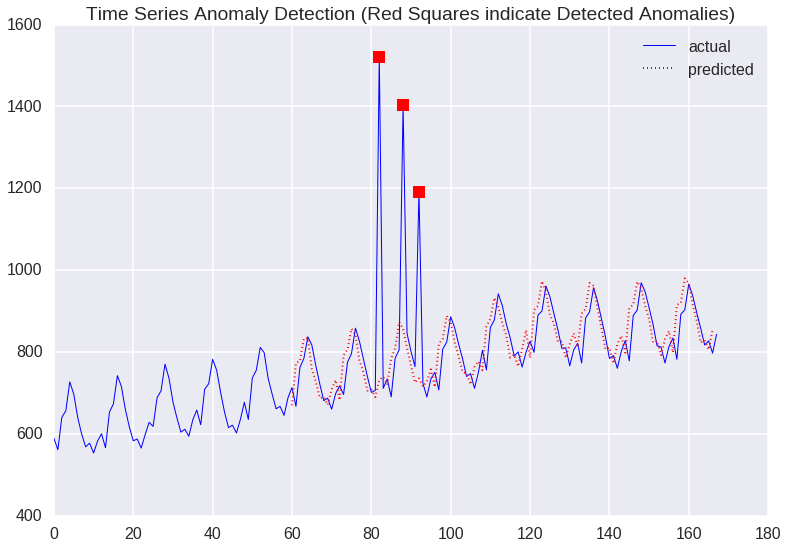

In [245]:
training_set_size = 60 

real_dataset = pd.read_csv('./data/milk_production.csv')
data = real_dataset['Production'].values.flatten()
index = np.arange(0, data.shape[0])

data = add_random_spike(data, training_set_size, 4)

lr, last_window = do_training(data, training_set_size = 60, window_size = 20)
predictions, predictions_index, outliners = pridict(lr, data, last_window,
                                                    training_set_size = 60, window_size = 20)

plt.plot(index, data, linewidth=1, color='blue', label='actual')
plt.plot(predictions_index, predictions, linewidth=2, color='red', linestyle='dotted', label='predicted')
for i in outliners:
    plt.plot(i[0], i[1], marker='s', color='red', linewidth=3)
    
plt.legend(loc=0)
plt.title('Time Series Anomaly Detection (Red Squares indicate Detected Anomalies)')+

##  Detecting Anomalies in Synthetic Dataset 

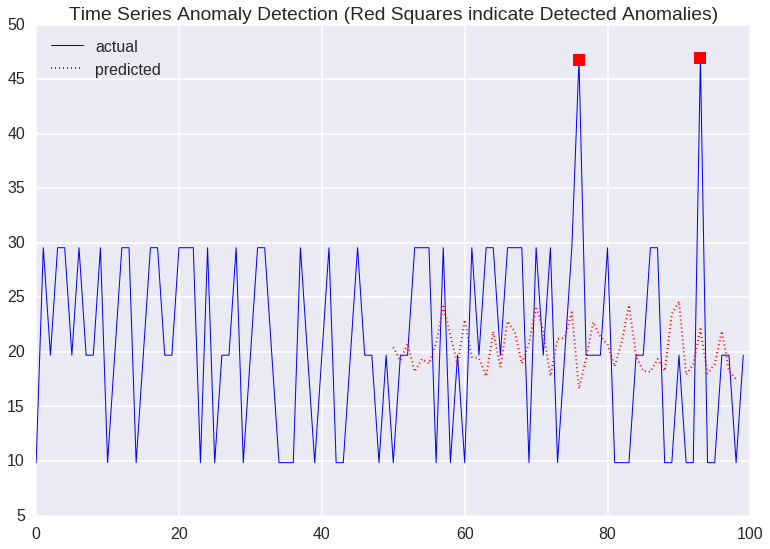

In [248]:
data, index = generate_dataset()

training_set = 50
window_size = 4
data = add_random_spike(data, after_this_point=training_set, num_of_spikes=2)

lr, last_window = do_training(data, training_set_size = training_set, window_size = window_size)
predictions, predictions_index, outliners =  pridict(lr, data, last_window,
                                                    training_set_size = training_set, window_size = window_size,
                                                    outline_cutoff = 20.0)
plt.plot(index, data, linewidth=1, color='blue', label='actual')
plt.plot(predictions_index, predictions, linewidth=2, color='red', linestyle='dotted', label='predicted')
for i in outliners:
    plt.plot(i[0], i[1], marker='s', color='red', linewidth=3)
    
plt.legend(loc=0)
plt.title('Time Series Anomaly Detection (Red Squares indicate Detected Anomalies)')
plt.show()